<a href="https://colab.research.google.com/github/Lalitgis/gee-tutorials/blob/main/Biomass_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import xarray as xr

In [2]:
%%capture
!pip install xee
import xee

In [6]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-lalitbc9',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [8]:
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [9]:
roi = map.draw_last_feature.geometry()

In [10]:
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          67.957179,
                          5.788909
                        ],
                        [
                          67.957179,
                          36.52569
                        ],
                        [
                          92.220244,
                          36.52569
                        ],
                        [
                          92.220244,
                          5.788909
                        ],
                        [
                          67.957179,
                          5.788909
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [25]:
biomass = (
    ee.ImageCollection("NASA/ORNL/biomass_carbon_density/v1").select('agb')
    .first().rename('biomass')
)


ndvi = (
    ee.ImageCollection("MODIS/061/MOD13A2")
    .select('NDVI', 'EVI')
    .filterDate('2010', '2011')
    .mean()
    .rename('ndvi', 'evi')
)

lai = (
    ee.ImageCollection("MODIS/061/MOD15A2H")
    .select('Lai_500m', 'Fpar_500m')
    .filterDate('2010', '2011')
    .mean()
    .rename('lai', 'fpar')
)

temp = (
    ee.ImageCollection("MODIS/061/MYD11A2")
    .select('LST_Day_1km')
    .filterDate('2010', '2011')
    .mean()
    .rename('temp')
)

pr = (
    ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V07")
    .select('precipitation')
    .filterDate('2010', '2011')
    .sum()
    .rename('pr')
)

lc= (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .select('LC_Type1')
    .filterDate('2010', '2011')
    .first()
    .rename('lc')
)

In [26]:
# Stack layers
stack = ee.Image.cat([
    ndvi, lai, temp, pr, lc, biomass
    ])
stack

In [27]:
ds = xr.open_dataset(
    stack,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.1,
    geometry = roi
)

In [28]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 1, lon: 243, lat: 307)
Coordinates:
  * time     (time) int64 8B 0
  * lon      (lon) float64 2kB 68.01 68.11 68.21 68.31 ... 92.01 92.11 92.21
  * lat      (lat) float64 2kB 5.839 5.939 6.039 6.139 ... 36.24 36.34 36.44
Data variables:
    ndvi     (time, lon, lat) float32 298kB ...
    evi      (time, lon, lat) float32 298kB ...
    lai      (time, lon, lat) float32 298kB ...
    fpar     (time, lon, lat) float32 298kB ...
    temp     (time, lon, lat) float32 298kB ...
    pr       (time, lon, lat) float32 298kB ...
    lc       (time, lon, lat) float32 298kB ...
    biomass  (time, lon, lat) float32 298kB ...
Attributes:
    crs:      EPSG:4326

In [29]:
df = ds.to_dataframe().dropna()

In [30]:
df.head()

ndvi         evi       lai      fpar  \
time lon       lat                                                     
0    68.007179 23.738909  700.434753  351.434784  1.065217  6.434783   
               23.838909  422.956512  225.695648  1.021739  5.913043   
               23.938909  469.739136  264.173920  1.086957  6.695652   
               24.038909  205.434784  126.043480  1.543478  6.717391   
               24.138909  735.478271  479.173920  1.956522  9.565217   

                                  temp     pr    lc   biomass  
time lon       lat                                             
0    68.007179 23.738909  15313.311523  1.021  17.0  0.123610  
               23.838909  15224.133789  1.057  16.0  0.103729  
               23.938909  15243.068359  1.057  16.0  0.108708  
               24.038909  15317.775391  0.969  17.0  0.139702  
               24.138909  15596.489258  0.889  16.0  0.644375

In [31]:
x = df[['ndvi', 'lai', 'fpar', 'temp', 'pr', 'lc', 'evi']]
y = df['biomass']

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [34]:
from xgboost import XGBRegressor

In [35]:
model = XGBRegressor(
    n_estimator =100,
    random_state = 42
)

In [36]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=100, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [37]:
y_pred = model.predict(x_test)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
import numpy as np

In [41]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE:{rmse}')
r2 = r2_score(y_test, y_pred)
print(f'R2:{r2}')

RMSE:4.738633057065267
R2:0.873878002166748


In [42]:
df['predicted_biomass'] = model.predict(x)

In [43]:
df.head()

ndvi         evi       lai      fpar  \
time lon       lat                                                     
0    68.007179 23.738909  700.434753  351.434784  1.065217  6.434783   
               23.838909  422.956512  225.695648  1.021739  5.913043   
               23.938909  469.739136  264.173920  1.086957  6.695652   
               24.038909  205.434784  126.043480  1.543478  6.717391   
               24.138909  735.478271  479.173920  1.956522  9.565217   

                                  temp     pr    lc   biomass  \
time lon       lat                                              
0    68.007179 23.738909  15313.311523  1.021  17.0  0.123610   
               23.838909  15224.133789  1.057  16.0  0.103729   
               23.938909  15243.068359  1.057  16.0  0.108708   
               24.038909  15317.775391  0.969  17.0  0.139702   
               24.138909  15596.489258  0.889  16.0  0.644375   

                          predicted_biomass  
time lon       lat                           
0    68.007179 23.738909           0.277521  
               23.838909           0.488432  
               23.938909           0.295065  
               24.038909           0.175517  
               24.138909           0.396861

In [44]:
xarr = df.to_xarray().sortby('lon').sortby('lat')

In [45]:
xarr

<xarray.Dataset> Size: 3MB
Dimensions:            (time: 1, lon: 243, lat: 306)
Coordinates:
  * time               (time) int64 8B 0
  * lon                (lon) float64 2kB 68.01 68.11 68.21 ... 92.01 92.11 92.21
  * lat                (lat) float64 2kB 5.939 6.039 6.139 ... 36.24 36.34 36.44
Data variables:
    ndvi               (time, lon, lat) float32 297kB nan nan ... nan 1.074e+03
    evi                (time, lon, lat) float32 297kB nan nan nan ... nan 792.2
    lai                (time, lon, lat) float32 297kB nan nan nan ... nan 2.152
    fpar               (time, lon, lat) float32 297kB nan nan nan ... nan 11.85
    temp               (time, lon, lat) float32 297kB nan nan ... nan 1.455e+04
    pr                 (time, lon, lat) float32 297kB nan nan nan ... nan 0.268
    lc                 (time, lon, lat) float32 297kB nan nan nan ... nan 16.0
    biomass            (time, lon, lat) float32 297kB nan nan nan ... nan 0.2696
    predicted_biomass  (time, lon, lat) float32 297kB nan nan nan ... nan 0.3663

In [46]:
import matplotlib.pyplot as plt


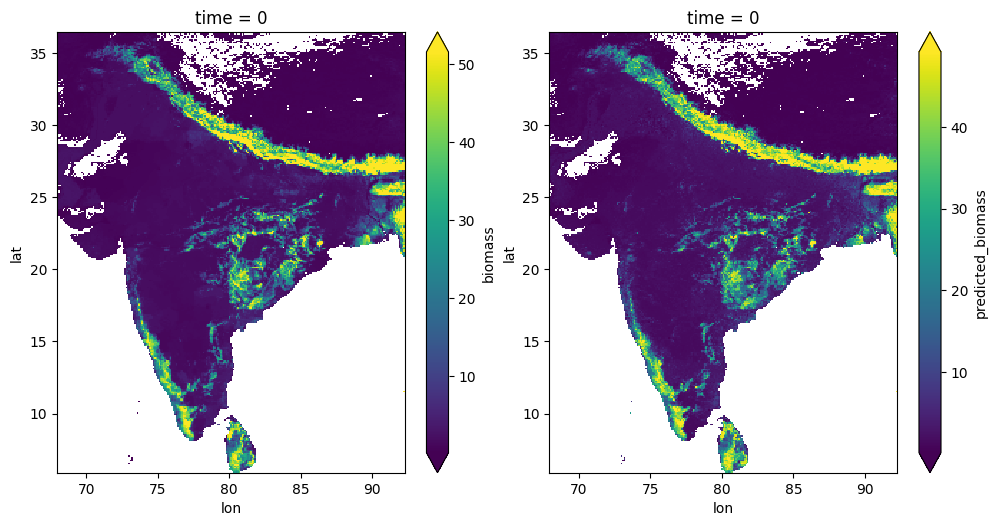

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
plt.tight_layout()

xarr.biomass.plot(
    ax = ax[0],
    x = 'lon',
    y = 'lat',
    robust = True
)

xarr.predicted_biomass.plot(
    ax = ax[1],
    x = 'lon',
    y = 'lat',
    robust = True
)

In [51]:
time_start = ee.Date('2020')
time_end = ee.Date('2021')


ndvi = (
    ee.ImageCollection("MODIS/061/MOD13A2")
    .select('NDVI', 'EVI')
    .filterDate(time_start, time_end)
    .mean()
    .rename('ndvi', 'evi')
)

lai = (
    ee.ImageCollection("MODIS/061/MOD15A2H")
    .select('Lai_500m', 'Fpar_500m')
    .filterDate(time_start, time_end)
    .mean()
    .rename('lai', 'fpar')
)

temp = (
    ee.ImageCollection("MODIS/061/MYD11A2")
    .select('LST_Day_1km')
    .filterDate(time_start, time_end)
    .mean()
    .rename('temp')
)

pr = (
    ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V07")
    .select('precipitation')
    .filterDate(time_start, time_end)
    .sum()
    .rename('pr')
)

lc= (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .select('LC_Type1')
    .filterDate(time_start, time_end)
    .first()
    .rename('lc')
)

stack_2020 = ee.Image.cat([
    ndvi, lai, temp, pr, lc])
stack_2020

In [52]:
ds2020 = xr.open_dataset(
    stack_2020,
    engine= 'ee',
    crs = 'EPSG:4326',
    scale = 0.1,
    geometry = roi
)

In [53]:
df2020 = ds2020.to_dataframe().dropna()
df2020

ndvi         evi       lai       fpar  \
time lon       lat                                                       
0    68.007179 23.738909   847.217407  369.565216  1.065217   6.260870   
               23.838909   601.739136  281.565216  2.195652   7.391304   
               23.938909   515.043457  265.739136  1.478261   7.304348   
               24.038909   326.347839  168.043472  1.826087   7.239130   
               24.138909   701.869568  459.260864  1.978261   8.739130   
...                               ...         ...       ...        ...   
     92.207179 35.938909  1487.478271  873.956543  2.347826  12.586957   
               36.038909  1257.695679  774.130432  1.934783  11.152174   
               36.138909  1129.347778  648.217407  1.934783  11.065217   
               36.238909  1255.782593  784.652161  2.478261  13.456522   
               36.438909  1186.521729  857.086975  2.434783  13.304348   

                                  temp     pr    lc  
time lon       lat                                   
0    68.007179 23.738909  15296.022461  1.171  17.0  
               23.838909  15242.045898  1.181  16.0  
               23.938909  15262.409180  1.290  16.0  
               24.038909  15299.232422  1.206  17.0  
               24.138909  15525.782227  1.166  16.0  
...                                ...    ...   ...  
     92.207179 35.938909  14324.933594  0.508  10.0  
               36.038909  14435.173828  0.478  16.0  
               36.138909  14132.239258  0.542  10.0  
               36.238909  14180.630859  0.564  10.0  
               36.438909  14654.413086  0.451  16.0  

[43659 rows x 7 columns]

In [54]:
df2020['biomass2020'] = model.predict(df2020[['ndvi', 'lai', 'fpar', 'temp', 'pr', 'lc', 'evi']])

In [55]:
df2020

ndvi         evi       lai       fpar  \
time lon       lat                                                       
0    68.007179 23.738909   847.217407  369.565216  1.065217   6.260870   
               23.838909   601.739136  281.565216  2.195652   7.391304   
               23.938909   515.043457  265.739136  1.478261   7.304348   
               24.038909   326.347839  168.043472  1.826087   7.239130   
               24.138909   701.869568  459.260864  1.978261   8.739130   
...                               ...         ...       ...        ...   
     92.207179 35.938909  1487.478271  873.956543  2.347826  12.586957   
               36.038909  1257.695679  774.130432  1.934783  11.152174   
               36.138909  1129.347778  648.217407  1.934783  11.065217   
               36.238909  1255.782593  784.652161  2.478261  13.456522   
               36.438909  1186.521729  857.086975  2.434783  13.304348   

                                  temp     pr    lc  biomass2020  
time lon       lat                                                
0    68.007179 23.738909  15296.022461  1.171  17.0     0.399449  
               23.838909  15242.045898  1.181  16.0     0.604346  
               23.938909  15262.409180  1.290  16.0     0.295771  
               24.038909  15299.232422  1.206  17.0     0.227915  
               24.138909  15525.782227  1.166  16.0     0.507894  
...                                ...    ...   ...          ...  
     92.207179 35.938909  14324.933594  0.508  10.0     0.527143  
               36.038909  14435.173828  0.478  16.0     0.355650  
               36.138909  14132.239258  0.542  10.0     0.368594  
               36.238909  14180.630859  0.564  10.0     0.536226  
               36.438909  14654.413086  0.451  16.0     0.366265  

[43659 rows x 8 columns]

In [56]:
xarr2020 = df2020.to_xarray().sortby('lon').sortby('lat')

In [57]:
xarr2020

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 1, lon: 243, lat: 306)
Coordinates:
  * time         (time) int64 8B 0
  * lon          (lon) float64 2kB 68.01 68.11 68.21 68.31 ... 92.01 92.11 92.21
  * lat          (lat) float64 2kB 5.939 6.039 6.139 6.239 ... 36.24 36.34 36.44
Data variables:
    ndvi         (time, lon, lat) float32 297kB nan nan nan ... nan 1.187e+03
    evi          (time, lon, lat) float32 297kB nan nan nan ... 784.7 nan 857.1
    lai          (time, lon, lat) float32 297kB nan nan nan ... 2.478 nan 2.435
    fpar         (time, lon, lat) float32 297kB nan nan nan ... 13.46 nan 13.3
    temp         (time, lon, lat) float32 297kB nan nan nan ... nan 1.465e+04
    pr           (time, lon, lat) float32 297kB nan nan nan ... 0.564 nan 0.451
    lc           (time, lon, lat) float32 297kB nan nan nan ... 10.0 nan 16.0
    biomass2020  (time, lon, lat) float32 297kB nan nan nan ... nan 0.3663

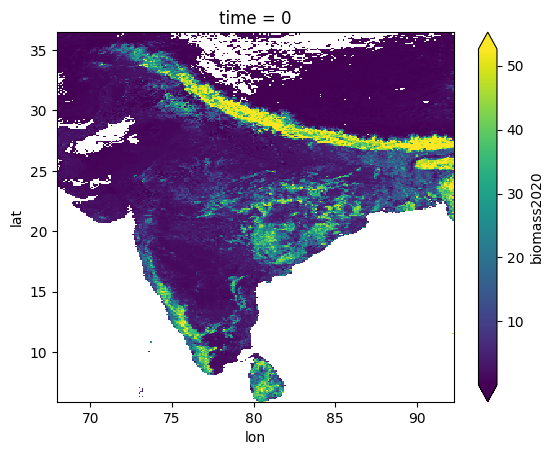

In [58]:
xarr2020.biomass2020.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

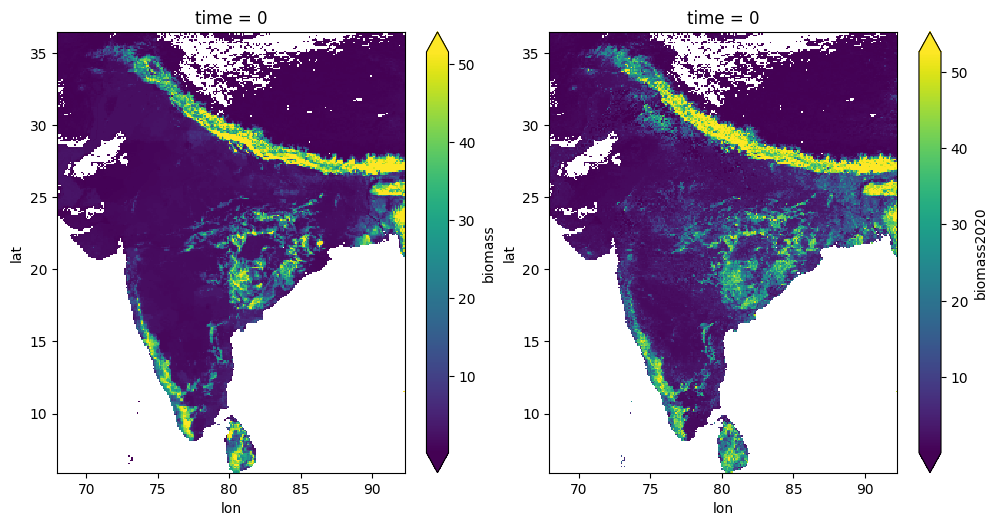

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
plt.tight_layout()

xarr.biomass.plot(
    ax = ax[0],
    x = 'lon',
    y = 'lat',
    robust = True
)

xarr2020.biomass2020.plot(
    ax = ax[1],
    x = 'lon',
    y = 'lat',
    robust = True
)